In [1]:
import numpy as np
import pylab as pl
import pandas as pd
%matplotlib inline

The `landmark_faces.txt` file on the course webpage has the locations in 2D of 68 landmark positions on 9780 faces. They are from https://susanqq.github.io/UTKFace/. In this assignment you are going to use PCA to transform these points, and feed the input into a classifier to predict the gender of each face. 

Upload your solution to https://apps.ecs.vuw.ac.nz/submit/DATA201 by 6pm on Friday 12th June at 6pm. 

Start by downloading the data and loading it into a dataframe.

In [2]:
df = pd.read_csv('./landmark_faces.txt', sep=' ', header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,1_0_2_20161219140530307.jpg,-4,71,-4,96,-3,120,-1,144,9,...,136,130,135,108,139,98,140,88,139,NaN
1,1_0_2_20161219140525218.jpg,13,76,13,96,15,117,18,137,25,...,137,121,141,102,141,94,142,85,143,NaN
2,1_0_2_20161219140540938.jpg,11,62,14,84,18,105,23,127,33,...,135,135,136,109,147,99,148,90,146,NaN
3,6_1_2_20161219140554092.jpg,36,66,34,86,38,108,45,129,54,...,140,120,154,104,168,97,167,92,166,NaN
4,1_1_2_20161219140604000.jpg,-3,60,-3,85,-1,110,3,134,12,...,137,126,141,109,153,98,154,88,153,NaN


For now, we will simply extract the locations for each landmark. They are stored as $x_1 y_1 x_2 y_2 \ldots x_{68} y_{68}$ in columns 1 to 136 of the dataframe. The following code will extract them into a data array, remove the first and last columns (the filename and the last column, which is blank), and make sure that numpy knows that the data are numbers.

In [4]:
data = df.to_numpy()
data = data[:,1:-1]
data = data.astype(float)

Get the size of the data array, and store the relevant information in variables `nfaces` and `npoints`

In [5]:
nfaces = data.shape[0]
npoints = data.shape[1]
data.shape

(9780, 136)

To plot a face, take one row of the data matrix, and plot the $x$ coordinates (even-numbered indices) against $y$ coordinates (odd-numbered ones). It is helpful to use `'.-'` to plot a line as well as the points. At first this will be upside down. One way to turn it the right way up is to use 1-data on the $y$ coordinates.

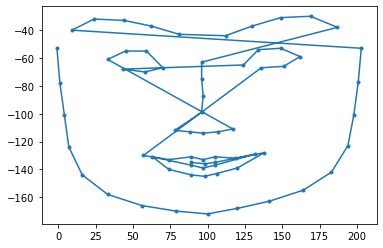

In [6]:
pl.plot(data[5][::2], 1-data[5][1::2], '.-')

The points are all meant to be matched on each face (the jargon for this is that they are 'corresponding points'). This means that to find the mean face (the average face, not a nasty-looking face) you just compute the mean of each datapoint. Compute this and plot it.

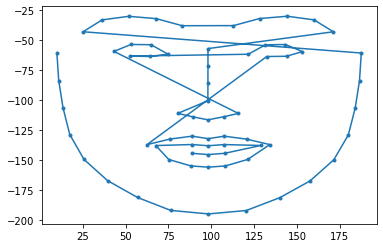

In [7]:
meanface = np.mean(data,axis=0)
pl.plot(meanface[0::2],1-meanface[1::2],'.-');

We've made the PCA algorithm a lot. Here it is again for your use. 

In [8]:
# Here is PCA

# Subtract off the mean
data = data - meanface

# Compute the covariance matrix
C = np.cov(data.T)

# Get the eigenvalues and eigenvectors
evals,evecs = np.linalg.eig(C)

# Now need to sort them into descending order
indices = np.argsort(evals)
indices = indices[::-1]
evecs = evecs[:,indices]
evals = evals[indices]

# Transform the data
newdata = np.dot(evecs.T,data.T).T

Compute the scree plot of the principal components and see how many you think might be useful.

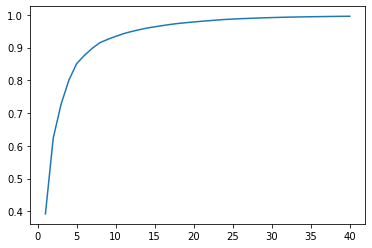

In [9]:
from sklearn.decomposition import PCA
x = 40
pca = PCA(n_components=x)
comps = pca.fit_transform(newdata)
cv = np.cumsum(pca.explained_variance_ratio_)
pl.plot(range(1, x+1), cv)

Reconstruct a face from the dataset using different numbers of dimensions, and plot both the original and reconstructed face. Use this to decide how many principal components you actually need. As a hint, here is the code to reconstruct the original data. You simply need to reduce the size of the eigenvector matrix appropriately in order to reconstruct lower-dimensional versions of it.

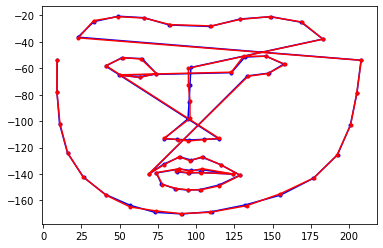

In [10]:
newdata = np.dot(data, evecs)
y=np.dot(newdata[:,:x], evecs.T[:x,:])+meanface
i=50
pl.plot(y[i,0::2],1-y[i,1::2],'b.-');
original = data[i,:]+meanface
pl.plot(original[0::2],1-original[1::2],'r.-');

The next code computes some a set of shapes. Look at the code, and explain what it is doing in a couple of sentences below. 

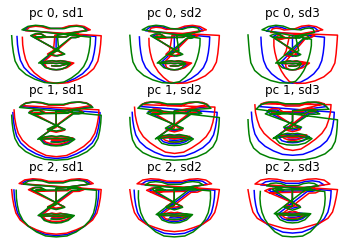

In [11]:
for pc in range(3):
    for sd in range(1,4):
        pl.subplot(3,3,pc*3+sd);
        pl.plot(meanface[0::2],1-meanface[1::2],'b')
        pl.plot(meanface[0::2] - np.sqrt(evals[pc])*sd*evecs[0::2,pc],1 - (meanface[1::2] - np.sqrt(evals[pc])*sd*evecs[1::2,pc]),'r') 
        pl.plot(meanface[0::2] + np.sqrt(evals[pc])*sd*evecs[0::2,pc],1 - (meanface[1::2] + np.sqrt(evals[pc])*sd*evecs[1::2,pc]),'g')         
        pl.title('pc {}, sd{}'.format(pc, sd))
        pl.axis('off')

#### The code seems to be using different number of PCs, and SDs to reconstruct the "mean face" to give a different face each time, such that:
- The first plot shows the original face
- The second plot changes the shape of the face
- The last plot shows the same face with a different facial exprission

To get training labels, look at the names of the images (which are in df[:,0]). The names are age_gender_race_date.jpg. We are interested in the gender, which is 0 or 1 for male and female (I'm not sure which is which, and it doesn't matter). Extract that digit (`stringname.find()` might be helpful, where stringname is a variable) and store it as the target variable. There is one error in the data, which is index 8513. I think you should assign it to category 0. 

In [12]:
names = df.loc[:,0]
males = list()
females = list()
labels = np.zeros(len(names))

for i in range(0, len(names)):
    ismale = names[i].split('_')[1] == '0'
    if i == 8513:
        labels[i] = 0
    elif ismale:
        labels[i] = 0
    else :
        labels[i] = 1

Now use a classification algorithm such as Support Vector Classifier from sklearn to classify the faces based on (i) the original data, and (ii) some small number of principal components. You should compare both the accuracy and time to train. Don't forget ot split the data into training and testing. You might find that very small numbers of principal components are good for this. 

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

x_train, x_test, y_train, y_test = train_test_split(data, labels, random_state=42)

svc = SVC()
svc.fit(x_train, y_train)

svc.score(x_test, y_test)

0.7541922290388549

In [14]:
predicted = svc.predict(x_test)
confusion_matrix(predicted, y_test)

array([[ 762,  281],
       [ 320, 1082]], dtype=int64)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(comps, labels, random_state=42)

svc.fit(x_train, y_train)
svc.score(x_test, y_test)

0.7464212678936605

In [24]:
predicted = svc.predict(x_test)
confusion_matrix(predicted, y_test)

array([[ 747,  285],
       [ 335, 1078]], dtype=int64)